## Load and Clean

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values='?')

In [3]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

In [4]:
df.drop(columns=['Date', 'Time'], inplace=True)

In [5]:
df.set_index('datetime', inplace=True)

In [6]:
df = df.astype(float)

In [7]:
missing = df.isna().sum()
print("Missing values:\n", missing)

Missing values:
 Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [8]:
df_clean = df.dropna()
print("New shape:", df_clean.shape)

New shape: (2049280, 7)


## Visual Inspection

In [9]:
import matplotlib.pyplot as plt

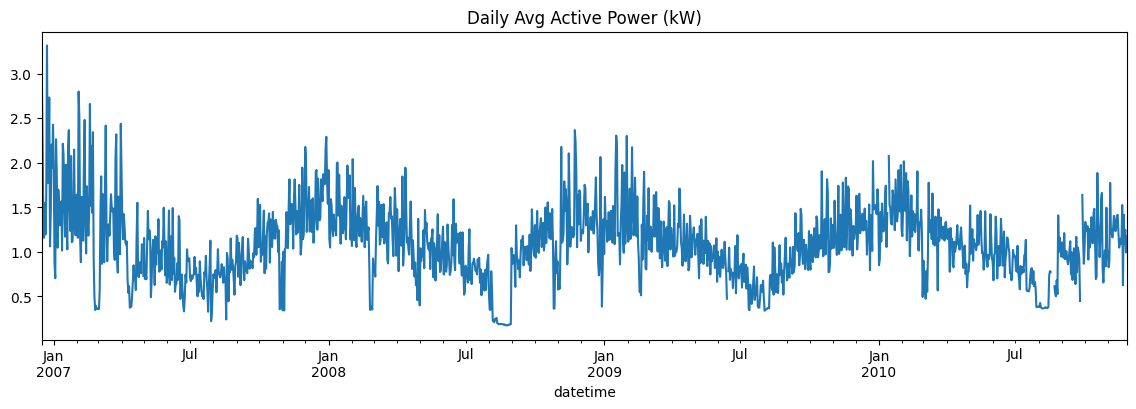

In [10]:
df['Global_active_power'].resample('D').mean().plot(title='Daily Avg Active Power (kW)', figsize=(14,4))
plt.show()

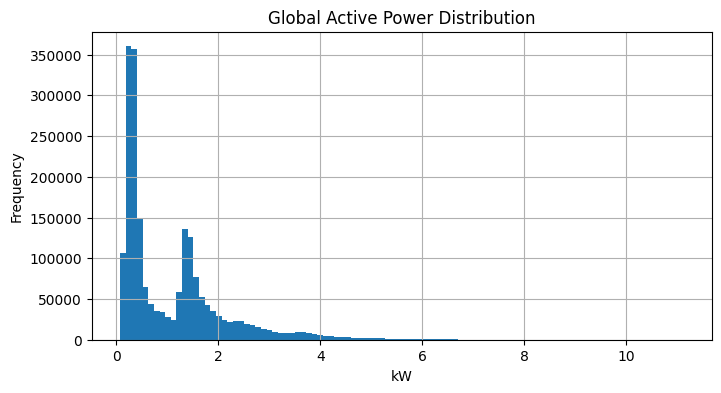

In [11]:
df['Global_active_power'].hist(bins=100, figsize=(8,4))
plt.title('Global Active Power Distribution')
plt.xlabel('kW')
plt.ylabel('Frequency')
plt.show()

In [12]:
df['unmetered_power'] = df['Global_active_power'] * 1000 / 60 - df['Sub_metering_1'] - df['Sub_metering_2'] - df['Sub_metering_3']

In [13]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['month'] = df.index.month

In [14]:
df['total_submetered'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']

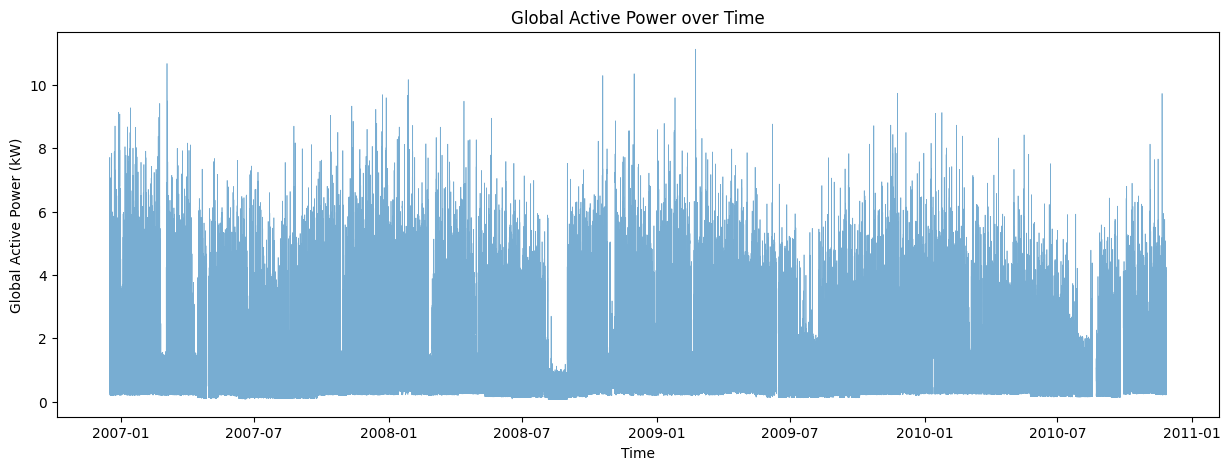

In [16]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df['Global_active_power'], lw=0.5, alpha=0.6)
plt.title('Global Active Power over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.show()

In [17]:
weekly_power = df['Global_active_power'].resample('W').mean()

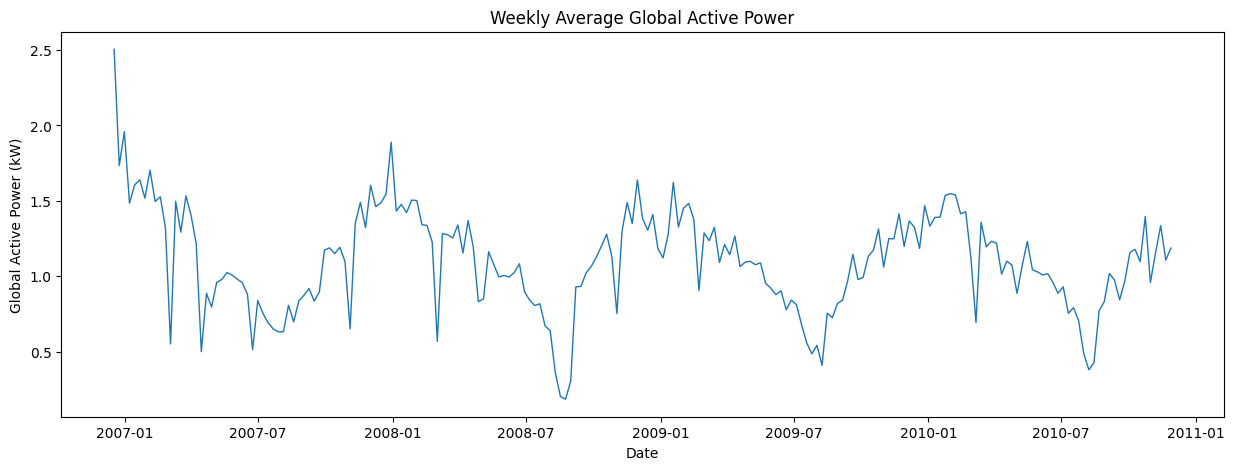

In [18]:
plt.figure(figsize=(15,5))
plt.plot(weekly_power, lw=1)
plt.title('Weekly Average Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.show()

In [19]:
hourly_usage = df.groupby(df.index.hour)[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].mean()
print(hourly_usage)

          Sub_metering_1  Sub_metering_2  Sub_metering_3
datetime                                                
0               0.364378        0.555392        2.966651
1               0.248958        0.397963        2.351931
2               0.145858        0.350133        2.027166
3               0.067765        0.350061        1.692080
4               0.047142        0.334048        1.866275
5               0.035703        0.315693        2.135749
6               0.039433        0.334299        4.236972
7               0.305204        0.503084       10.743926
8               1.371780        1.009836       12.657799
9               1.472912        1.079293       12.544001
10              1.133540        1.543708       11.450544
11              1.499484        1.997607       10.232991
12              1.568949        2.049556        9.100543
13              1.279892        2.431240        8.338575
14              1.472724        2.475124        7.376805
15              1.478507       

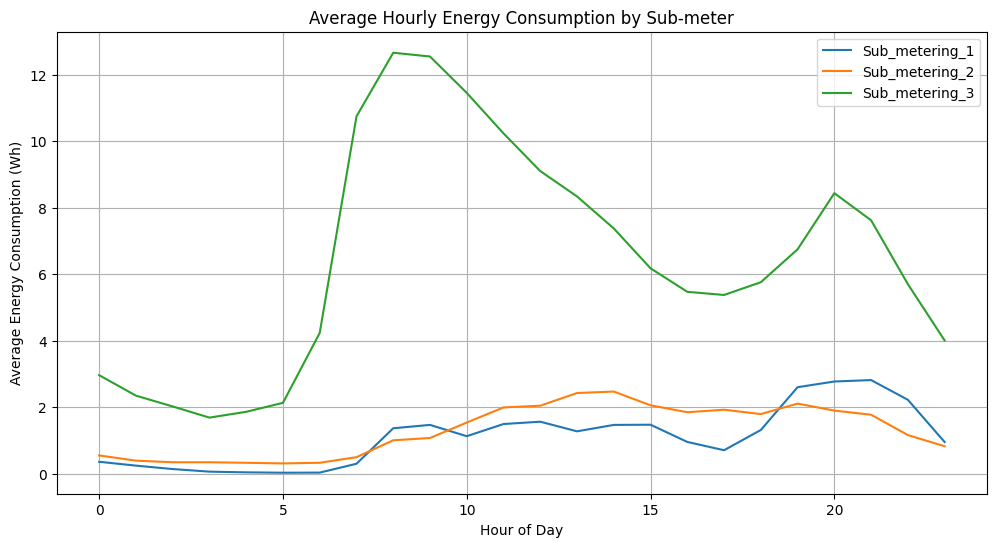

In [20]:
plt.figure(figsize=(12,6))
for column in ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    plt.plot(hourly_usage.index, hourly_usage[column], label=column)
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Consumption (Wh)')
plt.title('Average Hourly Energy Consumption by Sub-meter')
plt.legend()
plt.grid(True)
plt.show()

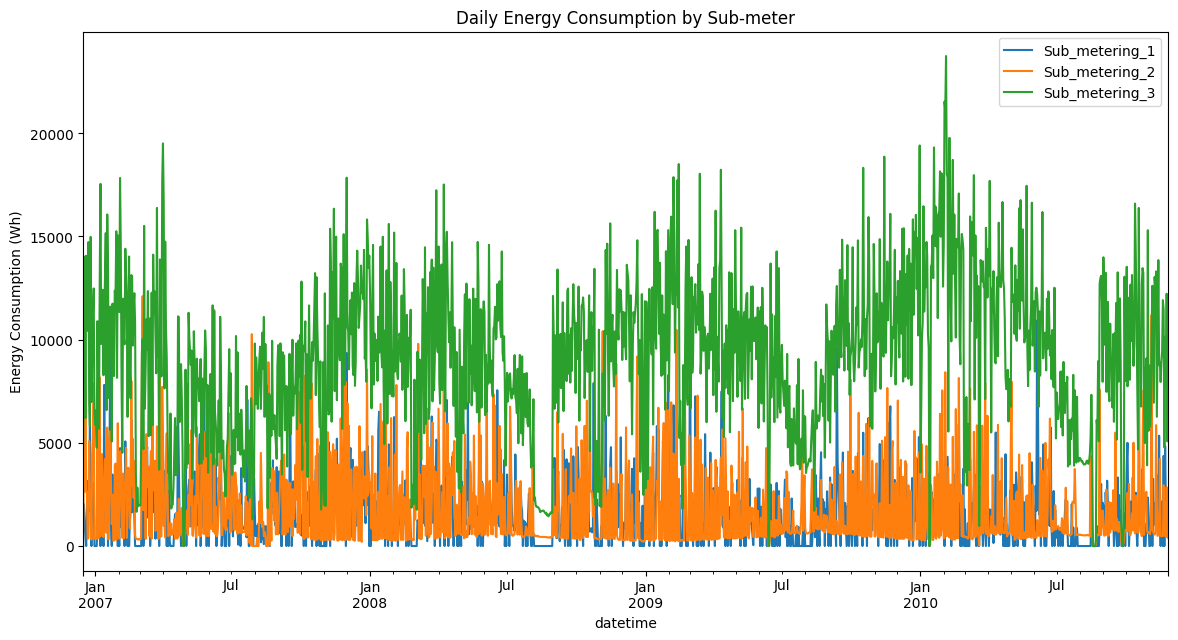

In [21]:
daily_usage = df.resample('D')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].sum()
daily_usage.plot(figsize=(14,7))
plt.title('Daily Energy Consumption by Sub-meter')
plt.ylabel('Energy Consumption (Wh)')
plt.show()

<Axes: xlabel='datetime'>

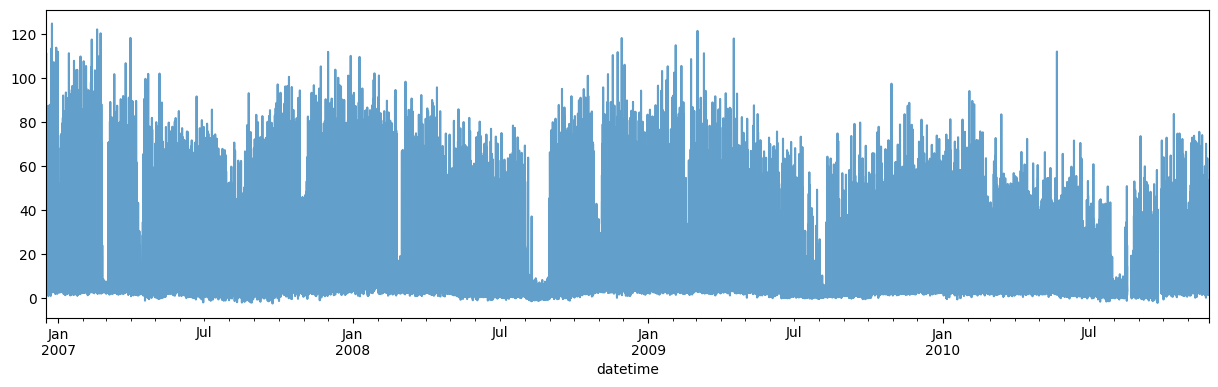

In [22]:
df["unmetered_power"].plot(figsize=(15,4), alpha=0.7)

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   unmetered_power        float64
 8   hour                   int32  
 9   weekday                int32  
 10  month                  int32  
 11  total_submetered       float64
dtypes: float64(9), int32(3)
memory usage: 182.1 MB


In [26]:
features = ["Sub_metering_1", "Sub_metering_2", "Sub_metering_3", "Global_active_power", "Global_reactive_power", "Voltage", "Global_intensity"]

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [28]:
from sklearn.ensemble import IsolationForest

In [31]:
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X_scaled)
df["anomaly_score"] = model.decision_function(X_scaled)
df["anomaly"] = model.predict(X_scaled)

C:\Users\Mehmet Öztürk\Desktop\Ders\Jupyter\IsoForest\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


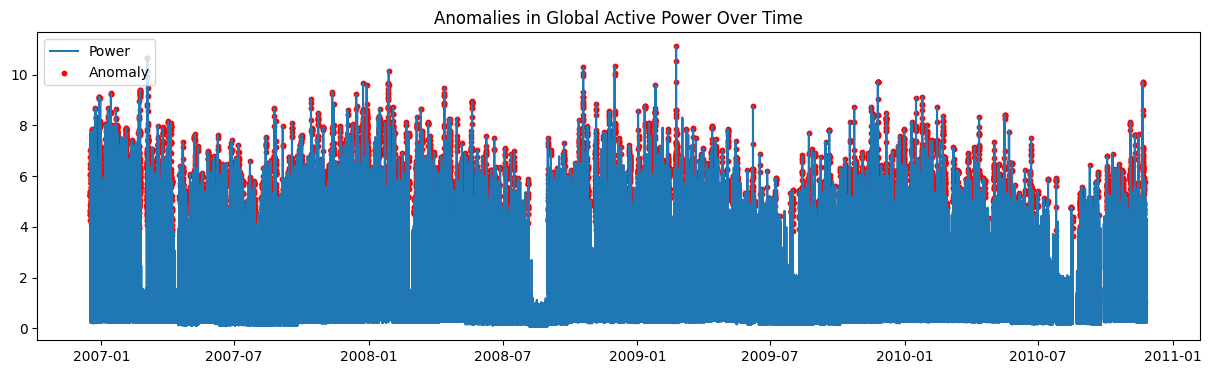

In [33]:
plt.figure(figsize=(15, 4))
plt.plot(df.index, df['Global_active_power'], label='Power')
plt.scatter(
    df[df['anomaly'] == -1].index,
    df[df['anomaly'] == -1]['Global_active_power'],
    color='red',
    label='Anomaly',
    s=10
)
plt.legend()
plt.title("Anomalies in Global Active Power Over Time")
plt.show()